In [1]:
import pandas as pd
import numpy as np
from datetime import date
import missingno as msn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from esm_datalayer_python import query_utils
import missingno as msn
import country_converter as coco

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
import pandas as pd

# time span: 2010-01-01 to 2019-12-31
# countries: AT+AU+BE+BR+CA+CH+CL+DE+DK+ES+FI+FR+GB+GR+HK+IE+IN+IT+JP+KR+LU+MX+NL+NO+PA+PT+SE+SG+TR+TW+US
# Frequency: Quarterly
# Measure: Amount outstanding
# CBS bank type: Domestic banks
# CBS reporting basis: Immediate counterparty basis
# Balance sheet position: International claims
# Type of instrument: All instruments
# Remaining maturity: All maturities
# Currency type of booking location: All currencies
# Counterparty sector: All sectors
# Counterparty country: 5J----All in total
urls = ["https://stats.bis.org/api/v2/data/dataflow/BIS/WS_CBS_PUB/1.0/Q.S.AT+AU+BE+BR+CA+CH+CL+DE+DK+ES+FI+FR+GB+GR+HK+IE+IN+IT+JP+KR+LU+MX+NL+NO+PA+PT+SE+SG+TR+TW+US.4B.F.I.A.A.TO1.A.5J?startPeriod=2010-01-01&endPeriod=2019-12-31&format=csv"]

df = pd.concat([pd.read_csv(url) for url in urls])

In [3]:
cols = ['L_REP_CTY', 'L_CP_COUNTRY', 'TIME_PERIOD', 'OBS_VALUE', 'OBS_STATUS']

data = df[cols].query("OBS_STATUS == 'A'")
data.drop(columns=['OBS_STATUS', 'L_CP_COUNTRY'], inplace=True)
data['treated'] = np.where(data['L_REP_CTY'] == 'GB' , 1, 0)

# convert TIME_PERIOD to datetime
data['TIME_PERIOD'] = pd.to_datetime(data['TIME_PERIOD'])

# change column names
data.columns = ['reporting_country', 'time_period', 'obs_value', 'treated']

C:\Users\c.wang\AppData\Local\Temp\ipykernel_3064\1280149521.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['TIME_PERIOD'] = pd.to_datetime(data['TIME_PERIOD'])


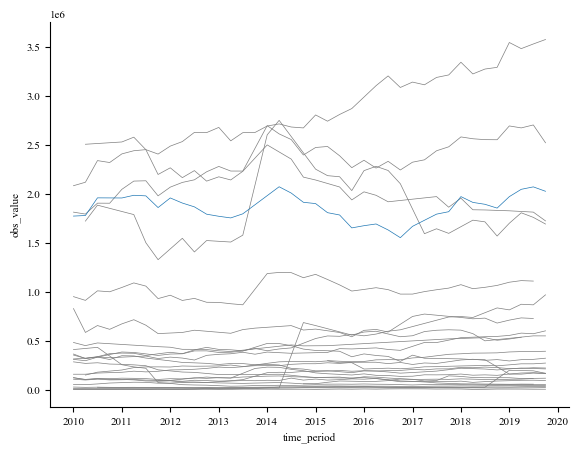

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6.7, 5))

sns.lineplot(data=data.query("treated==0"), x='time_period', y='obs_value', ax=ax, units='reporting_country', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=data.query("treated==1"), x='time_period', y='obs_value', ax=ax, units='reporting_country', estimator=None, color=colors[0], linewidth=0.5)

sns.despine()

---

In [5]:
# specify the environment, frequency, start date, end date you want to import
esm_env = "PROD"
freq = "A"
start_date = date(1990, 1, 31)
end_date = date(2023, 12, 31)

country_name = ['BE', 'DE', 'EE', 'IE', 'GR', 'ES', 'FR', 'IT', 'LU', 'NL', 'AT', 'PT', 'SI', 'SK', 'FI', 'CZ', 'DK', 'HU', 'PL', 'SE', 'GB', 'AU', 'CA', 'CL', 'IS', 'IL', 'JP', 'KR', 'MX', 'NZ', 'NO', 'CH', 'TR', 'US']

country_code = ['124', '134', '939', '178', '174', '184', '132', '136', '137', '138', '122', '182', '961', '936', '172', '935', '128', '944', '964', '144', '112', '193', '156', '228', '176', '436', '158', '542', '273', '196', '142', '146', '186', '111']

# import FDI inflow to GDP data
series = ["HAVER.B" + country + "FDIP@WDI" for country in country_code]

fdi_gdp = query_utils.exc_outseries_query(series, start_date, end_date, freq, esm_env)['payload']
fdi_gdp = pd.DataFrame(fdi_gdp, columns=['date'] + country_name)
# pivot the data
fdi_gdp = fdi_gdp.melt(id_vars='date', var_name='country', value_name='fdi_gdp')

# convert the date column to datetime
fdi_gdp['date'] = pd.to_datetime(fdi_gdp['date']).dt.date

# import FDI outflow to GDP data
series = ["HAVER.B" + country + "FDNP@WDI" for country in country_code]
fdi_gdp_out = query_utils.exc_outseries_query(series, start_date, end_date, freq, esm_env)['payload']
fdi_gdp_out = pd.DataFrame(fdi_gdp_out, columns=['date'] + country_name)
# pivot the data
fdi_gdp_out = fdi_gdp_out.melt(id_vars='date', var_name='country', value_name='fdi_gdp_out')
# add the data to the fdi_gdp dataframe
fdi_gdp['fdi_gdp_out'] = fdi_gdp_out['fdi_gdp_out']

In [6]:
fdi_gdp['treated'] = np.where(fdi_gdp['country'] == 'GB', 1, 0)
# compute the net FDI
fdi_gdp['net_fdi'] = fdi_gdp['fdi_gdp'] - fdi_gdp['fdi_gdp_out']
fdi_gdp = fdi_gdp.query("country != 'LU'")
#fdi_gdp = fdi_gdp.query("country != 'NL'")
fdi_gdp = fdi_gdp.query("country != 'IE'")
fdi_gdp = fdi_gdp.query("country != 'HU'")

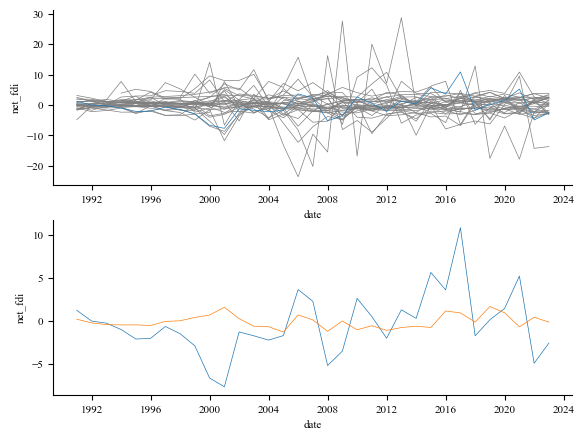

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=fdi_gdp.query("treated==0"), x='date', y='net_fdi', ax=ax[0], units='country', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=fdi_gdp.query("treated==1"), x='date', y='net_fdi', ax=ax[0], units='country', estimator=None, color=colors[0], linewidth=0.5)

sns.lineplot(data=fdi_gdp.query("treated==1"), x='date', y='net_fdi', ax=ax[1], units='country', estimator=None, color=colors[0], linewidth=0.5)
sns.lineplot(data=fdi_gdp.query("country=='US'"), x='date', y='net_fdi', ax=ax[1], units='country', estimator=None, color=colors[1], linewidth=0.5)

sns.despine()

---

In [25]:
fdi_inflow

,country_code,country_name,year,fdi_inflow
0,AFG,Afghanistan,1960,..
1,ALB,Albania,1960,..
2,DZA,Algeria,1960,..
3,ASM,American Samoa,1960,..
4,AND,Andorra,1960,..
...,...,...,...,...
13819,VIR,Virgin Islands (U.S.),2023,..
13820,PSE,West Bank and Gaza,2023,..
13821,YEM,"Yemen, Rep.",2023,..
13822,ZMB,Zambia,2023,..


In [21]:
# load fdi inflow and outflow data
fdi_inflow = pd.read_csv("data/fdi/fdi_inflow.csv")
fdi_outflow = pd.read_csv("data/fdi/fdi_outflow.csv")

# rename the columns
fdi_inflow.columns = ['country_name', 'country_code', 'series_name', 'series_code'] + list(range(1960, 2024))
fdi_outflow.columns = ['country_name', 'country_code', 'series_name', 'series_code'] + list(range(1960, 2024))

# convert country name to code
cc = coco.CountryConverter()
fdi_inflow['country_code'] = cc.convert(names=fdi_inflow['country_name'], to='ISO3')
fdi_outflow['country_code'] = cc.convert(names=fdi_outflow['country_name'], to='ISO3')

# drop if country code is not found
fdi_inflow = fdi_inflow.query("country_code != 'not found'")
fdi_outflow = fdi_outflow.query("country_code != 'not found'")

# drop country name, series name, and series code
fdi_inflow.drop(columns=['series_name', 'series_code'], inplace=True)
fdi_outflow.drop(columns=['series_name', 'series_code'], inplace=True)

# melt the data
fdi_inflow = fdi_inflow.melt(id_vars=['country_code', 'country_name'], var_name='year', value_name='fdi_inflow')
fdi_outflow = fdi_outflow.melt(id_vars=['country_code', 'country_name'], var_name='year', value_name='fdi_outflow')

# merge the data
fdi = pd.merge(fdi_inflow, fdi_outflow, on=['country_code', 'country_name', 'year'], how='outer')

# replace '...' with np.nan
fdi.replace('..', np.nan, inplace=True)
# drop if fdi_inflow and fdi_outflow are missing
fdi.dropna(subset=['fdi_inflow', 'fdi_outflow'], inplace=True)

# convert fdi_inflow and fdi_outflow to float
fdi['fdi_inflow'] = fdi['fdi_inflow'].astype(float)
fdi['fdi_outflow'] = fdi['fdi_outflow'].astype(float)

# copmute the net fdi
fdi['net_fdi'] = fdi['fdi_inflow'] - fdi['fdi_outflow']
# drop columns fdi_inflow and fdi_outflow
fdi.drop(columns=['fdi_inflow', 'fdi_outflow'], inplace=True)

# keep year >= 1990
fdi = fdi.query("year >= 1990")
# keep country if it has all the data from 1990
fdi = fdi.groupby('country_code').filter(lambda x: x.shape[0] == 33)

# add the treated column
fdi['treated_group'] = np.where(fdi['country_code'] == 'GBR', 1, 0)
# add post period column
fdi['post_period'] = np.where(fdi['year'] >= 2017, 1, 0)
# add treated post column
fdi['treated'] = fdi['treated_group'] * fdi['post_period']

C:\Users\c.wang\AppData\Local\Temp\ipykernel_3064\3143436567.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fdi.replace('..', np.nan, inplace=True)


In [22]:
drop_country = ['Liberia', 'Malta', 'Cyprus', 'Aruba']
fdi_drop = fdi.query("country_name not in @drop_country")

In [23]:
fdi[fdi.net_fdi < -40]

,country_code,country_name,year,net_fdi,treated_group,post_period,treated
30,ABW,Aruba,1990,-46.598639,0,0,0
3062,CYP,Cyprus,2014,-61.630722,0,0,0
3063,CYP,Cyprus,2015,-76.771417,0,0,0
6943,LBR,Liberia,1991,-102.856897,0,0,0
6945,LBR,Liberia,1993,-65.188279,0,0,0
6946,LBR,Liberia,1994,-55.916036,0,0,0
6948,LBR,Liberia,1996,-67.553952,0,0,0
6949,LBR,Liberia,1997,-95.068266,0,0,0
6952,LBR,Liberia,2000,-86.853154,0,0,0
6954,LBR,Liberia,2002,-43.164741,0,0,0


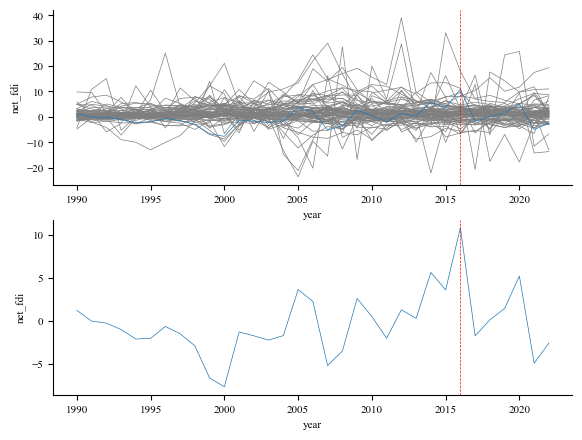

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=fdi_drop.query("treated_group==0"), x='year', y='net_fdi', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=fdi_drop.query("treated_group==1"), x='year', y='net_fdi', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
sns.lineplot(data=fdi_drop.query("treated_group==1"), x='year', y='net_fdi', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)

sns.despine()

In [20]:
fdi_drop

,country_code,country_name,year,net_fdi,treated_group,post,treated
350,ARE,United Arab Emirates,1990,-0.114728,0,0,0
351,ARE,United Arab Emirates,1991,0.030063,0,0,0
352,ARE,United Arab Emirates,1992,0.211146,0,0,0
353,ARE,United Arab Emirates,1993,0.666174,0,0,0
354,ARE,United Arab Emirates,1994,-0.867617,0,0,0
...,...,...,...,...,...,...,...
13690,ZAF,South Africa,2018,0.380619,0,1,0
13691,ZAF,South Africa,2019,0.507323,0,1,0
13692,ZAF,South Africa,2020,1.504447,0,1,0
13693,ZAF,South Africa,2021,9.653771,0,1,0
